In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data

Text(0.5, 1.0, 'Plot of average responses')

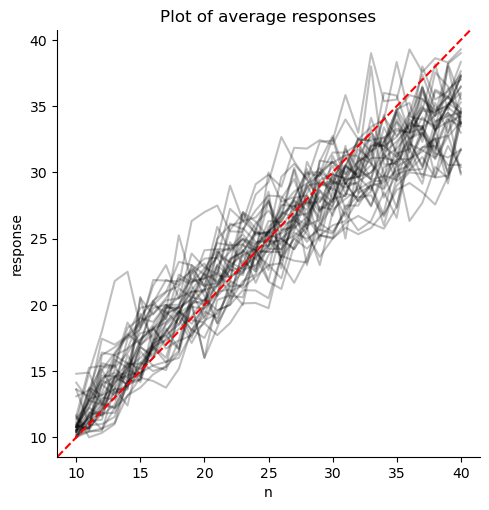

In [25]:
# Load data
df = pd.read_csv('resources/estimation_data.tsv', sep='\t', index_col=[0,1,2,3])
# Group by subject and n, then calculate mean response
grouped = df.groupby(['subject', 'n'])['response'].mean().reset_index()

# Plot one line per subject, all in the same color
sns.relplot(
    x='n',
    y='response',
    units='subject',  # This ensures one line per subject, but same color
    estimator=None,   # Required when using units
    data=grouped,
    kind='line',
    color='k',        # All lines will be black
    legend=False,
    alpha=.25,
)
plt.axline((10, 10), slope=1, color='r', linestyle='--')

plt.title('Plot of average responses')

## Step 1
**1. Define the Generative Model**
- **Encoding function:** $f(x) = x^\alpha$


In [26]:
import tensorflow as tf
import tensorflow_probability as tfp

n_r_grid = 1000
alpha = .1  # Tuning parameter
nu = .1     # Noise standard deviation

@tf.function
def to_sensory_space(x, alpha=0.5, x_min=10., x_max=40.):
    r_min = x_min**alpha
    r_max = x_max**alpha
    r = x**alpha
    r = (r - r_min) / (r_max - r_min)  # Normalize to [0, 1]
    return r




 - **Noise model:** $r \sim \mathcal{N}(f(x_0), \nu^2)$

In [27]:
# Evaluate normal distributions
def p_r_given_x0(x0, r_grid, alpha, nu, truncate=True):
    mu = to_sensory_space(x0, alpha=alpha)  # Shape: (n_x0,)
    # Reshape for broadcasting: mu (n_x0, 1), r_grid (n_r_grid,)
    mu = tf.expand_dims(mu, 1)  # Shape: (n_x0, 1)
    r_grid_expanded = tf.expand_dims(r_grid, 0)  # Shape: (1, n_r_grid)
    # Create a Normal distribution for each mu

    if truncate:
        # Truncate the distribution to [0, 1]
        dist = tfp.distributions.TruncatedNormal(loc=mu, scale=nu, low=0., high=1.)
    else:
        dist = tfp.distributions.Normal(loc=mu, scale=nu)

    # Evaluate PDF at r_grid points
    p = dist.prob(r_grid_expanded)  # Shape: (n_x0, n_r_grid)
    return p




**2. Build the Likelihood Grid**
- Create a grid of possible $x_0$ and $r$ values
- Make a $p(r | x_0)$ for each pair

Text(0.5, 0, 'Stimulus Value (x0)')

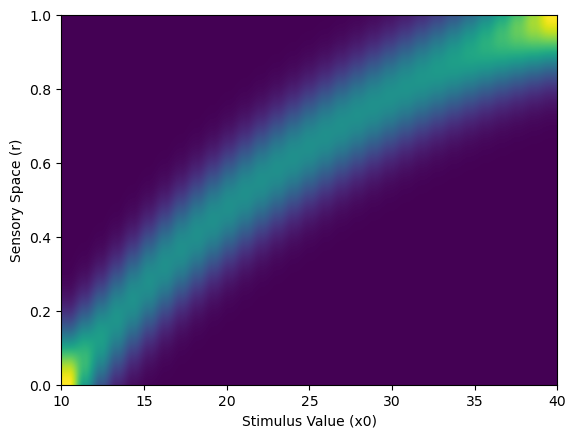

In [28]:
# Define stimulus values and sensory grid
x0 = tf.range(10.0, 41.0, dtype=tf.float32)
r_grid = tf.linspace(0.0, 1.0, n_r_grid)

likelihood = p_r_given_x0(x0, r_grid, alpha, nu, truncate=True)
plt.imshow(likelihood.numpy().T, extent=(10, 40, 0, 1), aspect='auto', origin='lower', cmap='viridis')
plt.ylabel('Sensory Space (r)')
plt.xlabel('Stimulus Value (x0)')


Text(0, 0.5, 'p(r | x0)')

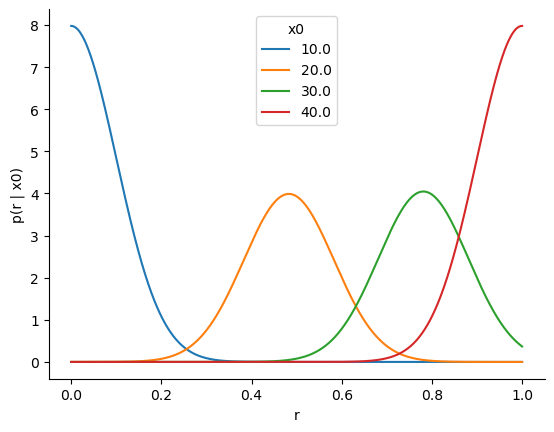

In [29]:
ll = pd.DataFrame(likelihood.numpy(), index=pd.Index(x0.numpy(), name='x0'),
                  columns=pd.Index(r_grid.numpy(), name='r'))
ll.loc[[10, 20, 30, 40], :].T.plot()
sns.despine()

plt.xlabel('r')
plt.ylabel('p(r | x0)')


**3. Bayesian Inference**
- For each observed $r$, compute the posterior:
  $$p(x|r) = \frac{p(r|x)p(x)}{p(r)}$$



In [30]:
def get_xhat_given_r(x0, likelihood):
    p_x0 = tf.ones_like(x0) / tf.cast(tf.size(x0), tf.float32)  # Uniform prior
    p_r = tf.reduce_sum(likelihood * p_x0[:, tf.newaxis], axis=0)  # Marginal likelihood p(r)
    p_x0_given_r = (likelihood * p_x0[:, tf.newaxis]) / p_r  # Posterior p(x0|r)
    # Expected value of x0 given r
    hat_x = tf.reduce_sum(x0[:, tf.newaxis] * p_x0_given_r, axis=0)  # Shape: (n_r_grid,)

    return hat_x

### Plot

Text(0, 0.5, 'x_hat')

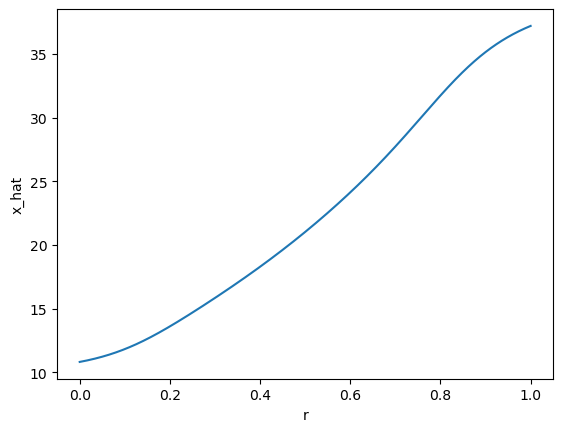

In [31]:
r = tf.linspace(0.0, 1.0, n_r_grid)

x_hat = get_xhat_given_r(x0, likelihood)
plt.plot(r, x_hat)
plt.xlabel('r')
plt.ylabel('x_hat')

- Estimate $\hat{x}$ as the expected value:
  $$\hat{x} = \mathbb{E}[x|r]$$

In [32]:
@tf.function
def get_p_x_hat_given_x0(hat_x, possible_x_hats ,likelihood, normalize=True, dx=1.):

    """
    returns p(x_hat | x_0) (shape: (n_x0, n_x_hat))
    """
    
    x_hat_edges = tf.concat([[possible_x_hats[0] - dx / 2.],
                             (possible_x_hats[:-1] + possible_x_hats[1:]) / 2.,
                             [possible_x_hats[-1] + dx / 2.]], axis=0)

    def get_distribution_over_xhat(ll):
        return tfp.stats.histogram(hat_x,
                            edges=x_hat_edges,
                            weights=ll)

    # x_0 x x_hat
    p_xhat_given_x0 = tf.vectorized_map(get_distribution_over_xhat, likelihood) 

    if normalize:
        p_xhat_given_x0 = p_xhat_given_x0 / tf.reduce_sum(p_xhat_given_x0, axis=0, keepdims=True)

        # Replace nans with 0s
        p_xhat_given_x0 = tf.where(tf.math.is_nan(p_xhat_given_x0), tf.zeros_like(p_xhat_given_x0), p_xhat_given_x0)

    return p_xhat_given_x0

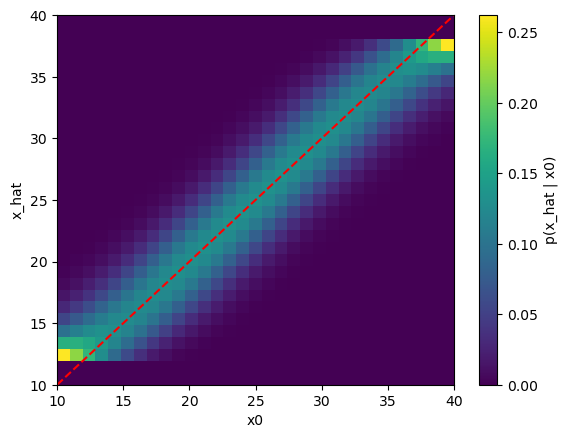

In [33]:
r_grid = tf.linspace(0.0, 1.0, n_r_grid)
alpha = 1.
nu = .1

likelihood = p_r_given_x0(x0, r_grid, alpha, nu)
hat_x = get_xhat_given_r(x0, likelihood)
x_hat_given_x0 = get_p_x_hat_given_x0(hat_x, tf.range(10.0, 41.0, dtype=tf.float32), likelihood)

plt.imshow(x_hat_given_x0.numpy().T, extent=(10, 40, 10, 40), aspect='auto', origin='lower', cmap='viridis')
plt.xlabel('x0')
plt.ylabel('x_hat')
plt.plot([10, 40], [10, 40], color='r', linestyle='--')
plt.colorbar(label='p(x_hat | x0)')

**4. Data Likelihood Function**
- Define a function that returns the response distribution over $\hat{x}$ for any $x_0$: $p(\hat{x} | x_0)$.


In [34]:
@tf.function
def data_likelihood(n, response, alpha, nu, n_r_grid=1000):
    r_grid = tf.linspace(0.0, 1.0, n_r_grid)
    # possible_x_hats, _ = tf.unique(response)
    possible_x_hats = tf.range(10.0, 41.0, dtype=tf.float32)

    likelihood = p_r_given_x0(x0, r_grid, alpha, nu)
    hat_x = get_xhat_given_r(x0, likelihood)
    x_hat_given_x0 = get_p_x_hat_given_x0(hat_x, possible_x_hats, likelihood)

    # get the indices of the values in n and response in possible_x_hats
    n_indices = tf.searchsorted(possible_x_hats, n)
    response_indices = tf.searchsorted(possible_x_hats, response)
    combined_indices = tf.stack([n_indices, response_indices], axis=1)

    # Get the likelihood of the data
    data_ll = tf.gather_nd(x_hat_given_x0, combined_indices)
    # Avoid log(0) by adding a small constant
    data_ll = tf.math.log(data_ll + 1e-10)
    return tf.reduce_sum(data_ll)


# Vectorize the grid search using tf.vectorized_map

In [35]:

# Vectorize for grid search
@tf.function
def grid_search(n, response, grid_alpha, grid_nu):
    def compute_ll(params):
        alpha, nu = params[0], params[1]
        return data_likelihood(n, response, alpha, nu)
    
    param_grid = tf.stack(tf.meshgrid(grid_alpha, grid_nu), axis=-1)
    param_grid = tf.reshape(param_grid, (-1, 2))
    ll_values = tf.vectorized_map(compute_ll, param_grid)
    return param_grid, ll_values

In [36]:
# Select data
data = df[~df.isnull().any(axis=1)].loc[1].astype(np.float32)

In [37]:
n_alpha = 20
n_nu = 20
grid_alpha = tf.linspace(0.1, 1.0, n_alpha)
grid_nu = tf.linspace(0.01, .3, n_nu)


pars, ll = grid_search(data['n'].values, data['response'].values, grid_alpha, grid_nu)

In [ ]:
How fast can you evaluate 400 differnet p

Text(0, 0.5, 'alpha')

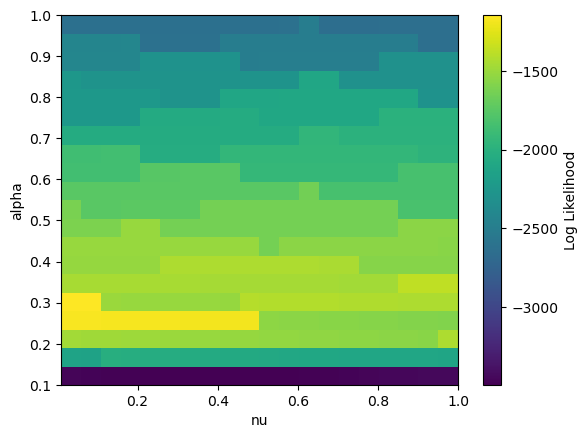

In [14]:
plt.imshow(ll.numpy().reshape(n_alpha, n_nu), extent=(0.01, 1.0, 0.1, 1.0), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Log Likelihood')
plt.xlabel('nu')
plt.ylabel('alpha')

In [15]:
# Get best fitting parameters:
best_idx = tf.argmax(ll)
best_params = pars[best_idx]
best_alpha, best_nu = best_params[0].numpy(), best_params[1].numpy()
print(f'Best alpha: {best_alpha}, Best nu: {best_nu}')

Best alpha: 0.10000000149011612, Best nu: 0.07105263322591782


## Assignment

We have now code that can fit the two-parameter model using grid search.

Can you now:

 * Plot the model's predictions for the x_hat versus the actual data.
 * What about the border conditions $x_0 = 10$ or $x_0 = 40$. What do you notice?
 * How could you improve the model to solve this issue?
 * What happens when you reduce the grid size over r? Which tradeoff is to be made here?

 * Fit the model to all subjects and plot predictions and distributions over parameters

Let's try to further imrpove model fit using gradient descent:

In [16]:
import tensorflow as tf
import tensorflow_probability as tfp

# Initialize trainable variables
alpha = tf.Variable(0.1, dtype=tf.float32, name='alpha')
nu = tf.Variable(0.1, dtype=tf.float32, name='nu')

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Data
n = tf.constant(data['n'].values, dtype=tf.float32)
response = tf.constant(data['response'].values, dtype=tf.float32)

# Gradient descent loop
for step in range(100):
    with tf.GradientTape() as tape:
        # Compute loss
        loss = -data_likelihood(n, response, alpha, nu)

    # Compute gradients
    gradients = tape.gradient(loss, [alpha, nu])

    # Check gradients
    if any(g is None for g in gradients):
        print("No gradients for some variables!")
        print("Gradients:", gradients)
        break

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, [alpha, nu]))

    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.numpy():.4f}, alpha: {alpha.numpy():.4f}, nu: {nu.numpy():.4f}")


LookupError: No gradient defined for operation'loop_body/histogram/count_integers/bincount/DenseBincount/pfor/while/DenseBincount' (op type: DenseBincount). In general every operation must have an associated `@tf.RegisterGradient` for correct autodiff, which this op is lacking. If you want to pretend this operation is a constant in your program, you may insert `tf.stop_gradient`. This can be useful to silence the error in cases where you know gradients are not needed, e.g. the forward pass of tf.custom_gradient. Please see more details in https://www.tensorflow.org/api_docs/python/tf/custom_gradient.

What is the issue here? How can we solve this?

Implement a model with a different transfer function, e.g. $f(x) = \log x$ (standard approach in numerosity research). Which model fits better?